# Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summit import *
from multitask import *

from rdkit import Chem

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from IPython.display import clear_output
from copy import deepcopy
import pathlib
import json

In [3]:
def make_average_plot(results: List[Experiment], ax, label=None, color=None):
    objective = results[0].domain.output_variables[0].name
    yields = [r.data[objective] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label, linewidth=2, c=color)
    ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1, color=color)

def make_comparison_plot(*args, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)
    for arg in args:
        make_average_plot(arg['results'], ax, label=arg["label"], color=arg.get("color"))
    fontdict = fontdict={"size":12}
    ax.legend(loc = "lower right", prop=fontdict)
    ax.set_xlim(0,20)
    ax.set_xticks(np.arange(0, 20, 2).astype(int))
#     ax.set_ylabel('Yield', fontdict=fontdict)
#     ax.set_xlabel('Reactions', fontdict=fontdict)
    ax.tick_params(direction='in')
    return ax

## Import Files

In [13]:
multitask_path = pathlib.Path("../data/multitask_results")
multitask_dirs = multitask_path.glob("*")

In [14]:
all_experiments = {}
for multitask_dir in multitask_dirs:
    json_files  = multitask_dir.glob("*.json")
    experiments = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            runner_dict = json.load(f)
            experiments.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))
    name = multitask_dir.parts[-1]
    all_experiments[name] = experiments

Text(0.02, 0.5, 'Yield (%)')

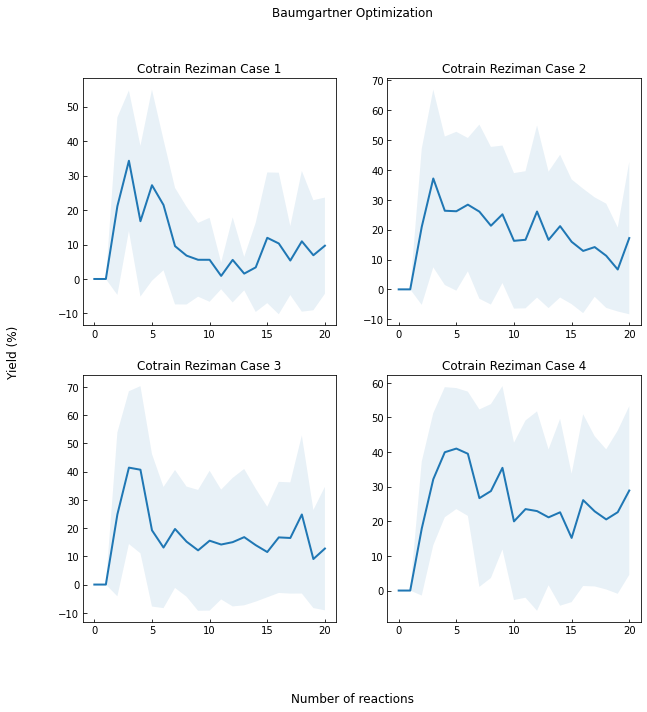

In [15]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(1,5):
    exps = all_experiments[f"results_baumgartner_suzuki_cotrain_reizman_suzuki_case_{i}"]
    ax = fig.add_subplot(2,2, i)
    make_average_plot(exps, ax, "MTBO")
    ax.set_title(f"Cotrain Reziman Case {i}")
    ax.tick_params(direction="in")
fig.suptitle("Baumgartner Optimization")
fig.supxlabel("Number of reactions")
fig.supylabel("Yield (%)")

In [16]:
reizman_path = pathlib.Path("../data/reizman_suzuki")
reizman_results_path = reizman_path.glob("results_stbo_case_*/")

In [17]:
all_experiments_reizman_stbo = {}
for results_dir in reizman_results_path:
    json_files  = results_dir.glob("*.json")
    experiments = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            runner_dict = json.load(f)
            experiments.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))
    name = results_dir.parts[-1]
    all_experiments_reizman_stbo[name] = experiments

Text(0.02, 0.5, 'Yield (%)')

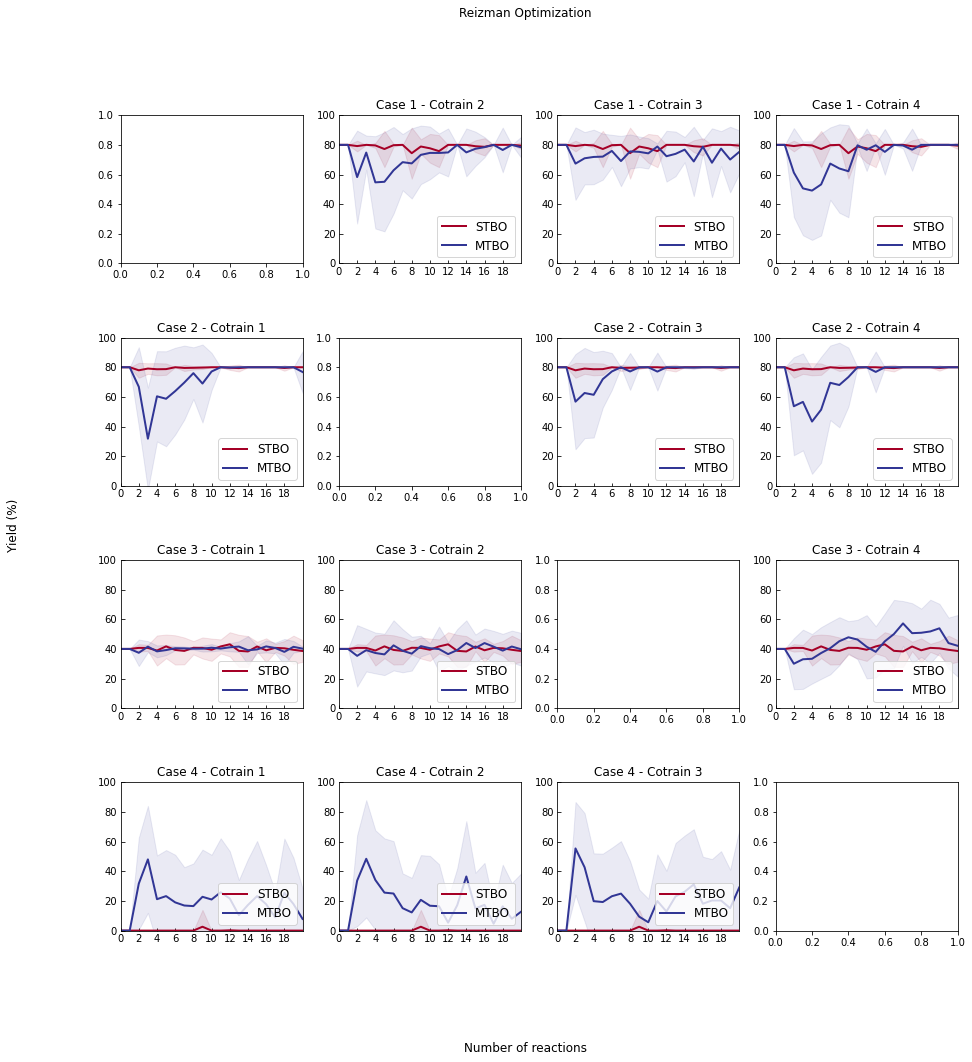

In [18]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
for i in range(1,5):
    for j in range(1,5):
        ax = fig.add_subplot(4,4, k)
        if i != j:
            stbo_exps = all_experiments_reizman_stbo[f"results_stbo_case_{i}"]
            mtbo_exps = all_experiments[f"results_reizman_suzuki_case_{i}_cotrain_reizman_suzuki_case_{j}"]
            make_comparison_plot(
                dict(results=stbo_exps, label="STBO", color="#a50026"),
                dict(
                    results=mtbo_exps,
                    label="MTBO",
                    color="#313695"
                ),
                ax=ax
            )
            ax.set_title(f"Case {i} - Cotrain {j}")
            ax.set_ylim(0,100)
        k+=1
fig.suptitle("Reizman Optimization")
fig.supxlabel("Number of reactions")
fig.supylabel("Yield (%)")

## Debugging

Does this work on the benchmarks directly from Summit?

In [34]:
exp = get_pretrained_reizman_suzuki_emulator()
exp.domain

Name,Type,Description,Values
catalyst,"categorical, input",Catalyst type - different ligands,8 levels
t_res,"continuous, input",Residence time in seconds (s),"[60.0,600.0]"
temperature,"continuous, input",Reactor temperature in degrees Celsius (ºC),"[30.0,110.0]"
catalyst_loading,"continuous, input",Catalyst loading in mol%,"[0.5,2.5]"
ton,"continuous, maximize objective",Turnover number - moles product generated divided by moles catalyst used,"[0.0,200.0]"
yield,"continuous, maximize objective",Yield,"[0.0,100.0]"


In [12]:
exp = get_pretrained_reizman_suzuki_emulator(case=4)
hierarchy =  {"yield": {"hierarchy": 0, "tolerance": 0.5}, "ton": {"hierarchy": 1, "tolerance": 1.0}}
transform = Chimera(exp.domain, hierarchy=hierarchy)
strategy = STBO(exp.domain, transform=transform)
r = Runner(strategy=strategy, experiment=exp, max_iterations=20)
r.run()

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/summit/strategies/base.py:697: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(arg))
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted m

<AxesSubplot:>

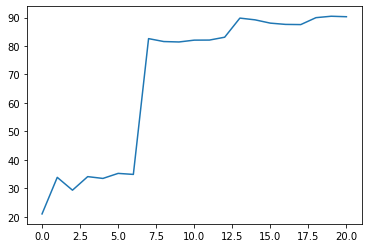

In [13]:
exp.data["yield"].plot()

In [14]:
exp.data

,catalyst,t_res,temperature,catalyst_loading,ton,yield,computation_t,experiment_t,strategy
0,P1-L5,195.000000,50.000000,2.000000,3.911138,21.005869,0.000000,0.051734,LHS
1,P1-L6,465.000000,90.000000,1.000000,45.315334,33.849083,0.000000,0.045005,LHS
2,P1-L6,418.770691,84.846581,0.852472,43.320717,29.343037,0.303623,0.034632,STBO
3,P1-L6,466.812012,85.764305,1.118436,39.133625,34.106148,0.507274,0.036822,STBO
4,P1-L6,492.722168,88.810745,0.970205,46.016396,33.471138,1.602792,0.034043,STBO
5,P1-L6,487.896912,91.735909,1.062502,45.542374,35.241810,0.733051,0.036841,STBO
6,P1-L6,487.499237,94.633339,0.998213,49.197529,34.884151,0.898356,0.036895,STBO
7,P1-L2,504.757477,98.467133,1.095336,76.155052,82.584763,0.275160,0.034053,STBO
8,P1-L2,495.489624,99.389221,1.032644,78.528931,81.557350,0.510932,0.037289,STBO
9,P1-L2,518.038757,99.667747,1.031086,78.871063,81.409203,1.352599,0.035046,STBO


yes, it does work.

Is there a problem with preprocessing and converting to a DataSet?

In [25]:
case_four_df = pd.read_csv(reizman_path / "reizman_suzuki_case_4.csv")

In [27]:
case_four_df.describe()

,NAME,t_res,temperature,catalyst_loading,ton,yld
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,48.000000,341.929897,86.831959,1.651722,47.690722,66.543299
std,28.145456,225.165490,23.908814,0.737427,32.076614,30.539329
min,0.000000,60.000000,30.000000,0.489000,0.000000,0.100000
25%,24.000000,154.100000,71.600000,1.096000,31.400000,53.600000
50%,48.000000,236.900000,93.000000,1.530000,39.400000,82.200000
75%,72.000000,600.000000,110.000000,2.501000,66.200000,86.500000
max,96.000000,600.000000,110.000000,2.510000,129.400000,99.800000


<AxesSubplot:>

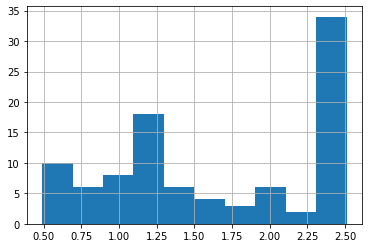

In [61]:
case_four_df["catalyst_loading"].hist()

In [4]:
# exp = SuzukiEmulator.load(model_name="reziman_suzuki_case_4", save_dir="../data/reizman_suzuki/emulator_case_4")
data_path = Path("../data/reizman_suzuki/ord/reizman_suzuki_case_4.pb")
ds = get_suzuki_dataset(
    data_path,
    split_catalyst=False,
    print_warnings=False,
)

In [9]:
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

In [10]:
dataset = message_helpers.load_message(str(data_path), dataset_pb2.Dataset)

In [15]:
volumes = [calculate_total_volume(r.inputs).magnitude for r in dataset.reactions]

In [16]:
pd.unique(volumes)

array([0.0175, 0.0335, 0.0175, 0.0335, 0.0335, 0.0335, 0.0175, 0.0335,
       0.0335, 0.0335, 0.0335, 0.0335, 0.0335, 0.0335, 0.0335, 0.0175,
       0.0175, 0.0175, 0.0335, 0.0175])

<AxesSubplot:>

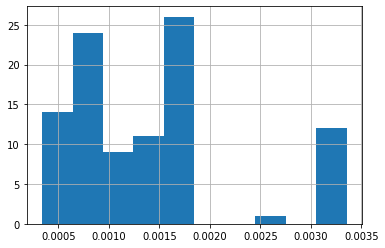

In [5]:
ds["catalyst_concentration"].hist()

<AxesSubplot:>

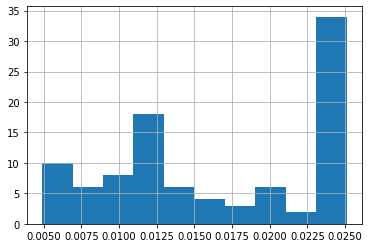

In [6]:
ds["catalyst_loading"].hist()

<AxesSubplot:>

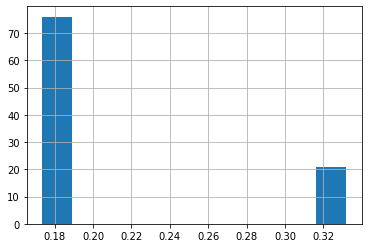

In [7]:
ds["reagent_concentration"].hist()

It seems that the issue is actually with using catalyst concentration instead of catalyst loading.

In [ ]:
exp =SuzukiEmulator.load(model_name="reizman_suzuki_case_4", save_dir="../data/reizman_suzuki/emulator_case_4/")
strategy = STBO(exp.domain)
r = Runner(strategy=strategy, experiment=exp, max_iterations=20)
r.run()

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.

In [11]:
exp.data

,catalyst_smiles,catalyst_loading,temperature,time,yld,computation_t,experiment_t,strategy
0,COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.CS(...,5.000000e-01,45.000000,195.000000,0.000000,0.000000,0.049125,LHS
1,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2...,1.500000e+00,95.000000,465.000000,0.000000,0.000000,0.041523,LHS
2,C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CS(=O)(=O)O[Pd]c...,1.049051e-01,20.709629,244.373871,3.723091,0.485233,0.030331,STBO
3,C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CS(=O)(=O)O[Pd]c...,1.646129e-01,23.460934,219.842773,1.557060,0.376441,0.030847,STBO
4,CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3cc...,6.810579e-02,19.999998,255.686707,8.328608,0.273804,0.032345,STBO
5,CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CC...,4.997638e-02,20.000002,261.902710,10.651909,0.249139,0.031644,STBO
6,CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CC...,2.980232e-08,19.999998,279.470154,12.653419,0.742221,0.031528,STBO
7,CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3cc...,-2.980232e-08,20.000000,301.133545,0.000000,0.456406,0.032374,STBO
8,CC(C)(C)P(C(C)(C)C)C(C)(C)C.CS(=O)(=O)O[Pd]c1c...,2.682072e-02,20.000000,261.859131,0.000000,0.326251,0.032886,STBO
9,CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CC...,7.192007e-02,20.000000,283.417999,8.464242,0.329834,0.032726,STBO


<AxesSubplot:>

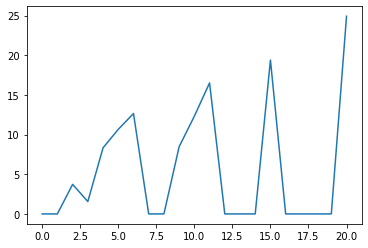

In [10]:
exp.data["yld"].plot()

## Archive

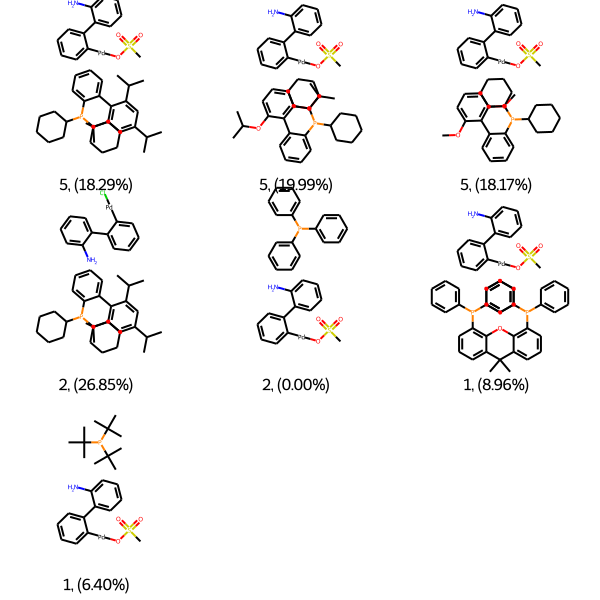

In [33]:
avg_yields = exps[0].data.groupby("catalyst_smiles")["yld"].mean()
cat_counts = exps[0].data["catalyst_smiles"].value_counts()
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in cat_counts.index],
    legends=[f"{v}, ({avg_yields[smiles]:.2f}%)" for smiles, v in zip(cat_counts.index, cat_counts)]
)
